# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: **01.11.2024**

Мягкий дедлайн: **13.11.24 23:59**

Жесткий дедлайн: **15.11.24 23:59**

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов + 2 балла бонус.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-03-gd-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

Напомним, что на лекциях и семинарах мы разбирали некоторые подходы к оптимизации функционалов по параметрам. В частности, был рассмотрен градиентный спуск и различные подходы к его реализации — полный градиентный спуск, стохастический градиентный спуск, метод импульса и другие. В качестве модели у нас будет выступать линейная регрессия.

В этом домашнем задании вам предстоит реализовать 4 различных вариации градиентного спуска, написать свою реализацию линейной регресии, сравнить методы градиентного спуска между собой на реальных данных и ещё много чего веселого и интересного!

In [2]:
from __future__ import annotations

from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type
from typing import List

import numpy as np

from descents import BaseDescent
from descents import get_descent

In [32]:
class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

## Задание 1. Реализация градиентного спуска (3.5 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле `descents.py`.

**Все реализуемые методы должны быть векторизованы!**

### Лирическое-теоретическое отступление № 1

Основное свойство антиградиента &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента,
пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (например, нулевой или сгенерированный из некоторого
случайного распределения). Тогда ванильный градиентный спуск состоит в повторении следующих шагов до сходимости:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

### Лирическое-теоретическое отступление № 2

На семинаре про [матрично-векторное дифференцирование](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem03-vector-diff.pdf) вы должны были обсуждать дифференцирование функции потерь MSE в матричном виде.

### Задание 1.0. Градиент MSE в матричном виде (0.02 балла).

Напомним, что функция потерь MSE записывается в матричном виде как:

$$
    Q(w) = \dfrac{1}{\ell} \left( y - Xw \right)^T \left( y - Xw \right)
$$

Выпишите ниже (подсмотрев в семинар или решив самостоятельно) градиент для функции потерь MSE в матричном виде.


$$ d_w Q = d_w \left[(y - Xw)^T (y - Xw)\right] $$

$$
d_w Q = d_w \left[(y - Xw)^T\right]  (y - Xw) + (y - Xw)^T d_w \left[(y - Xw)\right] =
$$

$$
= d_w \left[(-Xw)^T\right] (y - Xw) - (y - Xw)^T X \, dw =
$$

$$
= - dw^T \, X^T (y - Xw) - (y - Xw)^T X \, dw = -2(y - Xw)^T X \, dw
$$

$$ 2 X^T (y - Xw) = 0 $$

$$ X^T y = X^T X w $$


$$ w = (X^T X)^{-1} X^T y $$

### Задание 1.1. Родительский класс BaseDescent (0.5 балла).

Реализуйте функции `calc_loss` (вычисление MSE для переданных $x$ и $y$) и `predict` (предсказание $y_{pred}$ для переданных $x$) в классе `BaseDescent`.

Все вычисления должны быть векторизованы.

In [ ]:
class BaseDescent:
    def __init__(self, X: np.ndarray, y: np.ndarray):
        """
        Инициализация объекта класса BaseDescent
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        """
        self.X = X
        self.y = y
        self.w = np.dot(np.linalg.inv(X.T @ X), X.T @ y)

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычисления значения лосса (Mean Squared Error)
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значение функции потерь
        """
        loss = np.mean(np.square(np.dot(X, w) - y))
        return loss

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Функция для предсказания значений y
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :return: np.ndarray с предсказанными значениями
        """
        return np.dot(X, self.w)

### Задание 1.2. Полный градиентный спуск VanillaGradientDescent (0.5 балла).

Реализуйте полный градиентный спуск заполнив пропуски в классе `VanillaGradientDescent` в файле `descents.py`. Для вычисления градиента используйте формулу выше. Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

Здесь и далее функция `update_weights` должна возвращать разницу между $w_{k + 1}$ и $w_{k}$: $\quad w_{k + 1} - w_{k} = -\eta_{k} \nabla_{w} Q(w_{k})$. Кроме того, соответственно своему названию, она должна обновлять веса.

Во всех методах градиентного спуска мы будем использовать следующую формулу для длины шага:

$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$

На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

In [ ]:
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Update weights with respect to gradient
        :param gradient: gradient of the loss with respect to weights
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """

        old_w = self.w.copy()
        self.w -= self.lr() * gradient

        return self.w - old_w

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:

        y_pred = np.dot(x, self.w)
        gradient = (2 / x.shape[0]) * np.dot(x.T, (y_pred - y))

        return gradient

### Лирическое-теоретическое отступление № 3

Как правило, в задачах машинного обучения функционал $Q(w)$ представим в виде суммы $\ell$ функций:

$$
    Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        q_i(w).
$$

В нашем домашнем задании отдельные функции $q_i(w)$ соответствуют ошибкам на отдельных объектах.

Проблема метода градиентного спуска состоит в том, что на каждом шаге необходимо вычислять градиент всей суммы (будем его называть полным градиентом):

$$
    \nabla_w Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        \nabla_w q_i(w).
$$

Это может быть очень трудоёмко при больших размерах выборки. В то же время точное вычисление градиента может быть не так уж необходимо &ndash; как правило, мы делаем не очень большие шаги в сторону антиградиента, и наличие в нём неточностей не должно сильно сказаться на общей траектории.

Оценить градиент суммы функций можно средним градиентов случайно взятого подмножества функций:

$$
    \nabla_{w} Q(w_{k}) \approx \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}),
$$
где $B$ - это случайно выбранное подмножество индексов.

В этом случае мы получим метод **стохастического градиентного спуска**.

### Задание 1.3. Стохастический градиентный спуск StochasticDescent (0.5 балла).

Реализуйте стохастический градиентный спуск заполнив пропуски в классе `StochasticDescent`. Для оценки градиента используйте формулу выше (среднее градиентов случайно выбранного батча объектов). Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}).
$$

Размер батча будет являться гиперпараметром метода, семплируйте индексы для батча объектов с помощью `np.random.randint`.

In [ ]:
class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:

        batch_indices = np.random.randint(0, x.shape[0], self.batch_size)

        x_batch = x[batch_indices]
        y_batch = y[batch_indices]

        y_pred_batch = np.dot(x_batch, self.w)

        stoch_gradient = (2 / self.batch_size) * np.dot(x_batch.T, (y_pred_batch - y_batch))

        return stoch_gradient

### Лирическое-теоретическое отступление № 4

Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Например, если линии уровня функционала сильно вытянуты, то из-за ортогональности градиента линиям уровня он будет менять направление на почти противоположное на каждом шаге. Такие осцилляции будут вносить сильный шум в движение, и процесс оптимизации займёт много итераций. Чтобы избежать этого, можно усреднять векторы антиградиента с нескольких предыдущих шагов &ndash; в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введём для этого вектор инерции:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k})
\end{align}

Здесь $\alpha$ &ndash; параметр метода, определяющей скорость затухания градиентов с предыдущих шагов. Разумеется, вместо вектора градиента может быть использована его аппроксимация. Чтобы сделать шаг градиентного спуска, просто сдвинем предыдущую точку на вектор инерции:

$$
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

Заметим, что если по какой-то координате градиент постоянно меняет знак, то в результате усреднения градиентов в векторе инерции эта координата окажется близкой к нулю. Если же по координате знак градиента всегда одинаковый, то величина соответствующей координаты в векторе инерции будет большой, и мы будем делать большие шаги в соответствующем направлении.

### Задание 1.4 Метод Momentum MomentumDescent (0.5 балла).

Реализуйте градиентный спуск с методом инерции заполнив пропуски в классе `MomentumDescent`. Шаг оптимизации:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k}) \\
    &w_{k + 1} = w_{k} - h_{k + 1}.
\end{align}

$\alpha$ будет являться гиперпараметром метода, но в данном домашнем задании мы зафиксируем её за вас $\alpha = 0.9$.

In [ ]:
class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Update weights with respect to gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        old_w = self.w.copy()

        self.h = self.alpha * self.h + self.lr() * gradient

        self.w = self.w - self.h

        return self.w - old_w

### Лирическое-теоретическое отступление № 5

Градиентный спуск очень чувствителен к выбору длины шага. Если шаг большой, то есть риск, что мы будем перескакивать через точку минимума; если же шаг маленький, то для нахождения минимума потребуется много итераций. При этом нет способов заранее определить правильный размер шага &ndash; к тому же, схемы с постепенным уменьшением шага по мере итераций могут тоже плохо работать.

В методе AdaGrad предлагается сделать свою длину шага для каждой компоненты вектора параметров. При этом шаг будет тем меньше, чем более длинные шаги мы делали на предыдущих итерациях:

\begin{align}
    &G_{kj} = G_{k-1,j} + (\nabla_w Q(w_{k - 1}))_j^2; \\
    &w_{jk} = w_{j,k-1} - \frac{\eta_t}{\sqrt{G_{kj}} + \varepsilon} (\nabla_w Q(w_{k - 1}))_j.
\end{align}

Здесь $\varepsilon$ небольшая константа, которая предотвращает деление на ноль.

В данном методе можно зафксировать длину шага (например, $\eta_k = 0.01$) и не подбирать её в процессе обучения **(обратите внимание, что в данном домашнем задании длина шага не фиксируется)**. Отметим, что данный метод подходит для разреженных задач, в которых у каждого объекта большинство признаков равны нулю. Для признаков, у которых ненулевые значения встречаются редко, будут делаться большие шаги; если же какой-то признак часто является ненулевым, то шаги по нему будут небольшими.

У метода AdaGrad есть большой недостаток: переменная $G_{kj}$ монотонно растёт, из-за чего шаги становятся всё медленнее и могут остановиться ещё до того, как достигнут минимум функционала. Проблема решается в методе RMSprop, где используется экспоненциальное затухание градиентов:

$$
    G_{kj} = \alpha G_{k-1,j} + (1 - \alpha) (\nabla_w Q(w^{(k-1)}))_j^2.
$$

В этом случае размер шага по координате зависит в основном от того, насколько
быстро мы двигались по ней на последних итерациях.

Можно объединить идеи описанных выше методов: накапливать градиенты со всех прошлых шагов для
избежания осцилляций и делать адаптивную длину шага по каждому параметру.

### Задание 1.5. Метод Adam (Adaptive Moment Estimation) (1.5 балла).

Реализуйте градиентный спуск с методом Adam заполнив пропуски в классе `Adam`. Шаг оптимизации:

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{m}_{k} = \dfrac{m_k}{1 - \beta_1^{k}}, \quad \widehat{v}_{k} = \dfrac{v_k}{1 - \beta_2^{k}}; \\ \\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}.
\end{align}

$\beta_1 = 0.9, \beta_2 = 0.999$ и $\varepsilon = 10^{-8}$ будут зафиксированы за вас.

In [ ]:
class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Update weights & params
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.iteration += 1

        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * np.square(gradient)

        m_hat = self.m / (1 - self.beta_1 ** self.iteration)
        v_hat = self.v / (1 - self.beta_2 ** self.iteration)

        old_w = self.w.copy()

        self.w = self.w - (self.lr() / (np.sqrt(v_hat) + self.eps)) * m_hat

        return self.w - old_w

## Задание 2. Реализация линейной регресии (0.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `linear_regression.py` - **LinearRegression**. По сути линейная регрессия будет оберткой, которая запускает обучение

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускаются только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`;
    * Разность весов содержит наны;
    * Достижение максимального числа итераций `max_iter`.
* Будем считать, что все данные, которые поступают на вход имеют столбец единичек последним столбцом;
* Веса модели надо обновлять внутри функции `update_weights`, она неспроста так называется
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту) и значение функции потерь после оптимизации.

In [ ]:
class LinearRegression:
    """
    Linear regression class
    """

    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        """
        :param descent_config: gradient descent config
        :param tolerance: stopping criterion for square of euclidean norm of weight difference (float)
        :param max_iter: stopping criterion for iterations (int)
        """
        self.descent: BaseDescent = get_descent(descent_config)

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        """
        Fitting descent weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        x = np.asarray(x)
        y = np.asarray(y)

        x = np.hstack([x, np.ones((x.shape[0], 1))])

        for iteration in range(self.max_iter):

            self.loss_history.append(self.descent.calc_loss(x, y))


            gradient = self.descent.calc_gradient(x, y)
            weight_diff = self.descent.update_weights(gradient)

            if np.sum(np.square(weight_diff)) < self.tolerance:
                break
            if np.any(np.isnan(weight_diff)):
                break

        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return self.descent.calc_loss(x, y)

## Задание 3. Проверка кода (0 баллов)

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

import numpy as np

from descents import get_descent
from linear_regression import LinearRegression

In [ ]:
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [ ]:
# Descents

descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}

for descent_name in ['full', 'stochastic', 'momentum', 'adam']:
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)

    diff = descent.step(x, y)
    gradient = descent.calc_gradient(x, y)
    predictions = descent.predict(x)

    assert gradient.shape[0] == dimension, f'Gradient failed for descent {descent_name}'
    assert diff.shape[0] == dimension, f'Weights failed for descent {descent_name}'
    assert predictions.shape == y.shape, f'Prediction failed for descent {descent_name}'

In [ ]:
# LinearRegression

max_iter = 10
tolerance = 0

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': dimension,
        'batch_size': 10
    }
}

regression = LinearRegression(
    descent_config=descent_config,
    tolerance=tolerance,
    max_iter=max_iter
)

regression.fit(x, y)

assert len(regression.loss_history) == max_iter + 1, 'Loss history failed'

Если ваше решение прошло все тесты локально, то теперь пришло время протестировать его в [Яндекс Контесте](https://contest.yandex.ru/contest/54610/).

Для каждой задачи из контеста вставьте ссылку на успешную посылку:

* **VanillaGradientDescent**: https://contest.yandex.ru/contest/70588/problems/?success=123609498#48802/2020_09_02/M8HMGJfRzS


* **StochasticDescent**: https://contest.yandex.ru/contest/70588/run-report/123610366/


* **MomentumDescent**: https://contest.yandex.ru/contest/70588/problems/C/?success=123610483#528867/2020_09_02/E77Dv6IngP


* **Adam**: https://contest.yandex.ru/contest/70588/problems/D/?success=123610929#528867/2020_09_02/M5Kr6x1mtX


* **LinearRegression**: https://contest.yandex.ru/contest/70588/problems/E/?success=123611212#528867/2020_09_02/y87qalnuq1

P.S. надеюсь, я те ссылки вставила

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.

* Постройте график распределения целевой переменной в данных, подумайте, нужно ли заменить её на логарифм. Присутствуют ли выбросы в данных с аномальной ценой? Если да, то удалите их из данных.

* Проведите исследование данных:
    * Проанализируйте тип столбцов, постройте графики зависимости целевой переменной от признака, распределения значений признака;
    * Подумайте (и напишите): какие признаки могут быть полезными на основе этих графиков, обработайте выбросы;
    * Подумайте (и напишите): какие трансформации признаков из известных вам будет уместно применить;
    * Разделите полезные признаки на категориальные, вещественные и те, которые не надо предобрабатывать.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 8:1:1.

In [3]:
import numpy as np
import pandas as pd  # при желании, можете заменить на polars/pyspark или что угодно, что вам нравится

import matplotlib.pyplot as plt
import seaborn as sns

from descents import get_descent
from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [4]:
data = pd.read_csv('autos.csv')  # разумеется, если вы используете не pandas, это надо поменять

In [ ]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


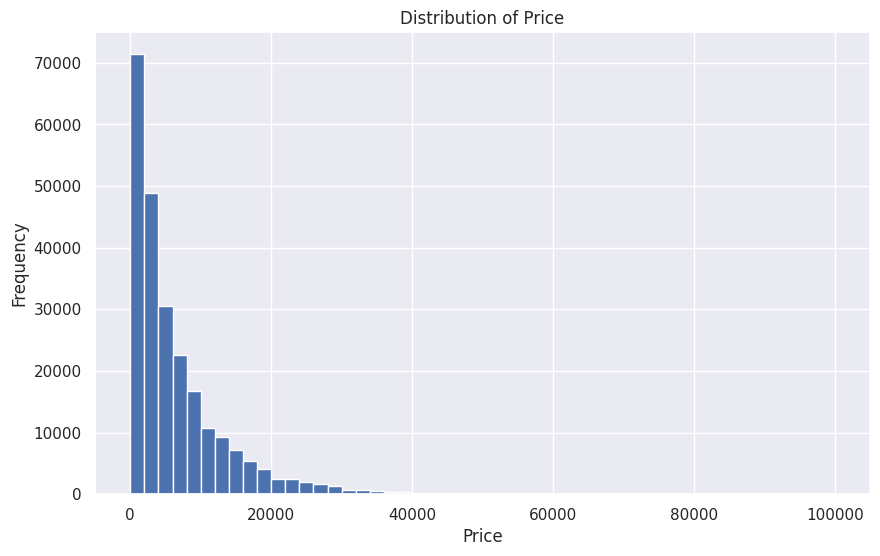

In [ ]:
data['price'].hist(bins=50, figsize=(10, 6))
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

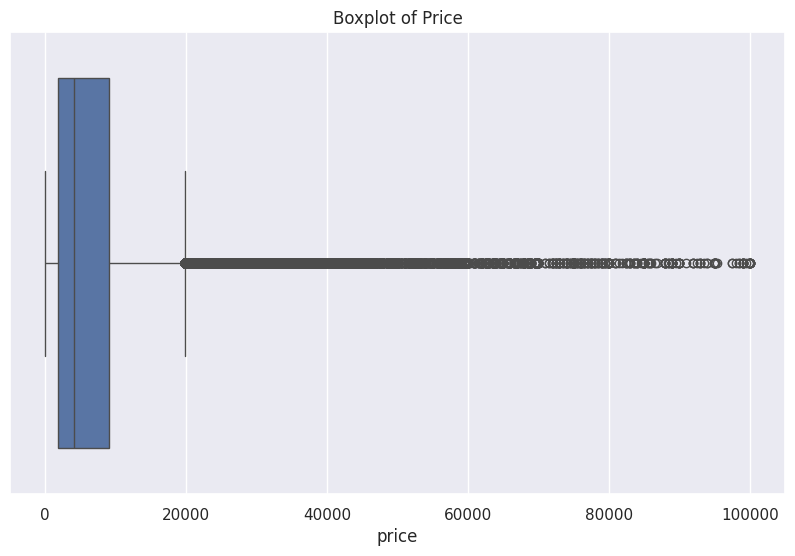

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['price'])
plt.title("Boxplot of Price")
plt.show()

Распределение цены демонстрирует значительную положительную асимметрию с выраженным правосторонним смещением и длинным правым хвостом, что свидетельствует о наличии существенной скошенности. Дополнительно, анализ с использованием диаграммы "ящик с усами" указывает на присутствие множества выбросов в данных о цене. С учетом этих особенностей логарифмирование целевой переменной представляется обоснованным шагом.

In [5]:
# удалим выбросы
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

<ipython-input-6-7f4c826ab47d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['log_price'] = np.log1p(filtered_data['price'])


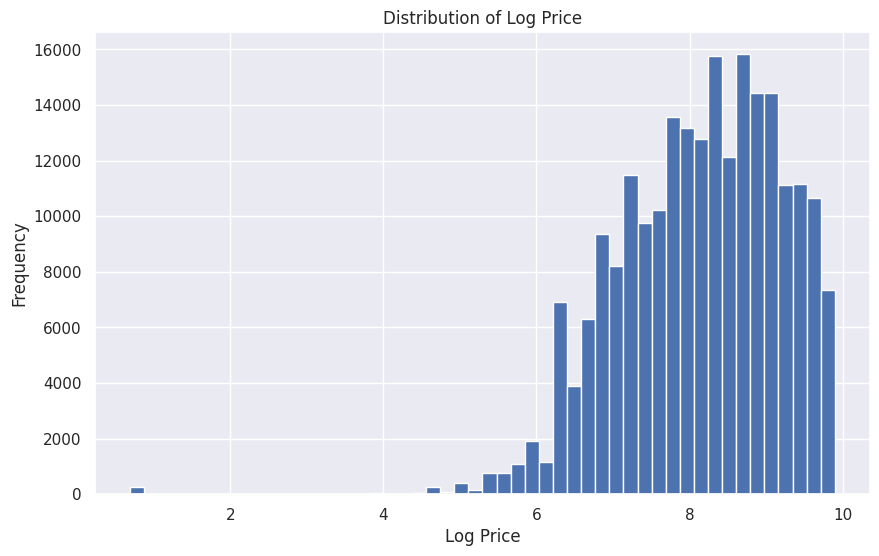

In [6]:
# логарифмируем целевую переменную и построим новый график распределения
filtered_data['log_price'] = np.log1p(filtered_data['price'])
filtered_data = filtered_data.drop(columns=['price'])

filtered_data['log_price'].hist(bins=50, figsize=(10, 6))
plt.title('Distribution of Log Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

In [ ]:
# тип данных в стобцах
filtered_data.dtypes

,0
brand,object
model,object
vehicleType,object
gearbox,object
fuelType,object
notRepairedDamage,object
powerPS,int64
kilometer,int64
autoAgeMonths,int64
log_price,float64


### **Анализ признаков**
Проанализируем зависимости целевой переменной от признака, распределения значений признака и определим, какие признаки могут быть полезными, а также обработаем выбросы, если они есть

#### Категориальные признаки
В нашем наборе данных имеются два признака, gearbox и notRepairedDamage, которые можно представить в виде бинарных значений. Эти признаки целесообразно объединить в новый столбец с бинарным кодированием, чтобы уменьшить количество переменных и упростить анализ.

Для остальных категориальных признаков, где количество уникальных значений превышает две вариации, будет использован подход кодирования, подходящий для многозначных категорий (например, one-hot или target encoding).

Анализ боксплотов показал, что переменные brand, vehicleType и fuelType обладают значительными различиями в медианах целевой переменной. Это свидетельствует о потенциальной полезности этих признаков для модели, так как они могут способствовать объяснению вариации цены.

В то же время, переменная model продемонстрировала относительно стабильное распределение медиан и отсутствие значимых различий между категориями. Это может указывать на её низкую предсказательную ценность. Исходя из этого, переменную model целесообразно исключить из модели, чтобы избежать добавления избыточных данных.

In [ ]:
print(f"Уникальные значения для 'brand': {filtered_data['brand'].nunique()}")
print(f"Уникальные значения для 'model': {filtered_data['model'].nunique()}")
print(f"Уникальные значения для 'vehicleType': {filtered_data['vehicleType'].nunique()}")
print(f"Уникальные значения для 'gearbox': {filtered_data['gearbox'].nunique()}")
print(f"Уникальные значения для 'fuelType': {filtered_data['fuelType'].nunique()}")
print(f"Уникальные значения для 'notRepairedDamage': {filtered_data['notRepairedDamage'].nunique()}")

Уникальные значения для 'brand': 38
Уникальные значения для 'model': 245
Уникальные значения для 'vehicleType': 8
Уникальные значения для 'gearbox': 2
Уникальные значения для 'fuelType': 7
Уникальные значения для 'notRepairedDamage': 2


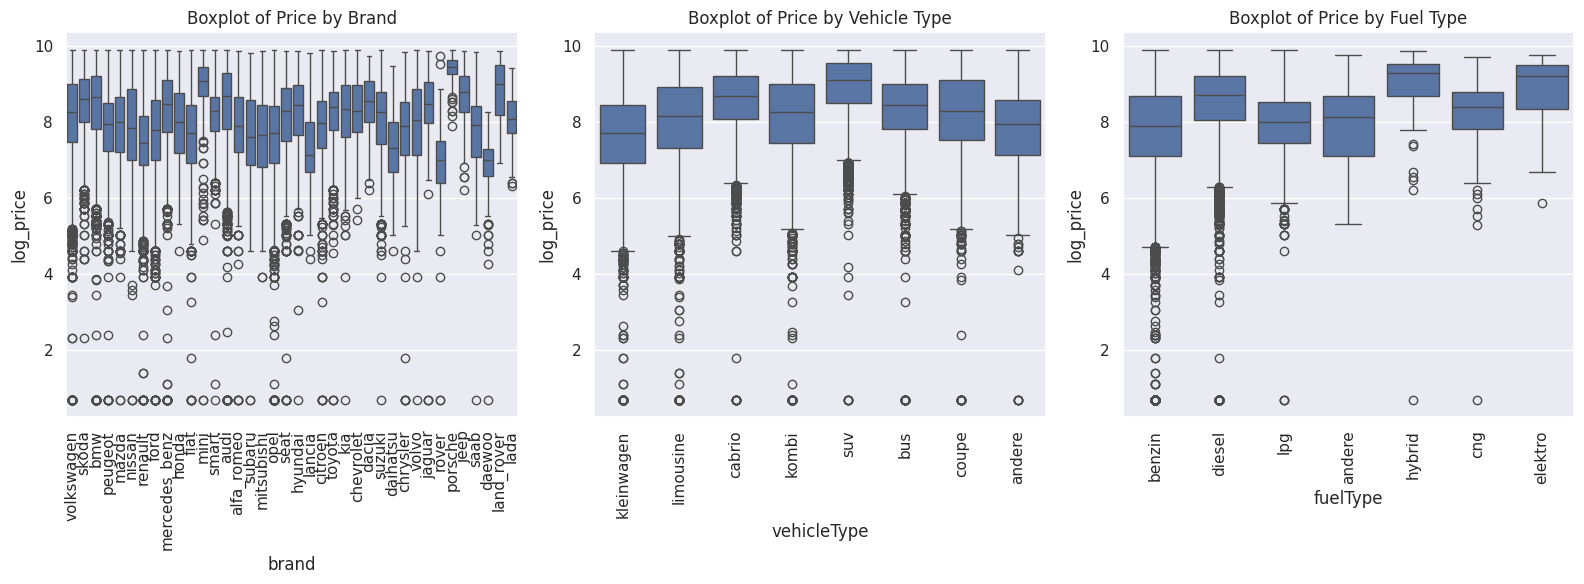

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.boxplot(data=filtered_data, x='brand', y='log_price')
plt.xticks(rotation=90)
plt.title("Boxplot of Price by Brand")

plt.subplot(1, 3, 2)
sns.boxplot(data=filtered_data, x='vehicleType', y='log_price')
plt.xticks(rotation=90)
plt.title("Boxplot of Price by Vehicle Type")

plt.subplot(1, 3, 3)
sns.boxplot(data=filtered_data, x='fuelType', y='log_price')
plt.xticks(rotation=90)
plt.title("Boxplot of Price by Fuel Type")

plt.tight_layout()
plt.show()

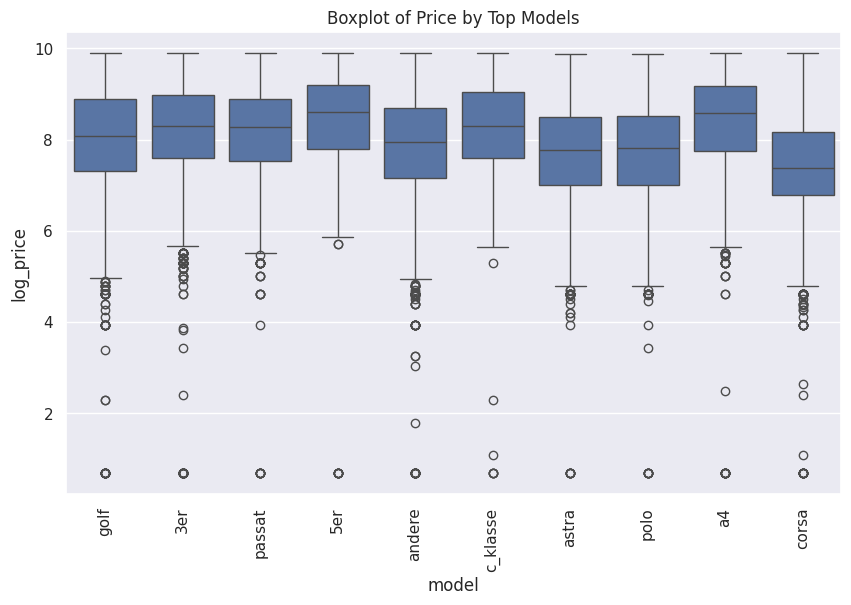

In [ ]:
top_models = filtered_data['model'].value_counts().nlargest(10).index
popular_models_data = filtered_data[filtered_data['model'].isin(top_models)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=popular_models_data, x='model', y='log_price')
plt.xticks(rotation=90)
plt.title("Boxplot of Price by Top Models")
plt.show()

In [7]:
filtered_data = filtered_data.drop(columns=['model'])

#### Числовые признаки

В датасете имеется три числовых признака: powerPS, kilometer и autoAgeMonths. Каждый из них демонстрирует умеренную корреляцию с целевой переменной, где powerPS имеет положительную корреляцию, тогда как kilometer и autoAgeMonths — отрицательную. Учитывая это, данные признаки целесообразно сохранить в модели линейной регрессии, так как они могут способствовать объяснению вариативности целевой переменной.

Анализ распределения значений данных признаков выявил, что powerPS и autoAgeMonths имеют правостороннюю асимметрию, что может привести к снижению эффективности модели. В связи с этим было принято решение очистить эти переменные от выбросов. Дополнительно к powerPS была применена логарифмизация для сглаживания распределения. Признак kilometer оставлен без изменений, так как его распределение соответствует естественной вариативности пробега для подержанных автомобилей.



In [ ]:
correlation_matrix = filtered_data[['powerPS', 'kilometer', 'autoAgeMonths', 'log_price']].corr()
correlation_matrix['log_price'].sort_values(ascending=False)

,log_price
log_price,1.000000
powerPS,0.457150
kilometer,-0.356145
autoAgeMonths,-0.613228


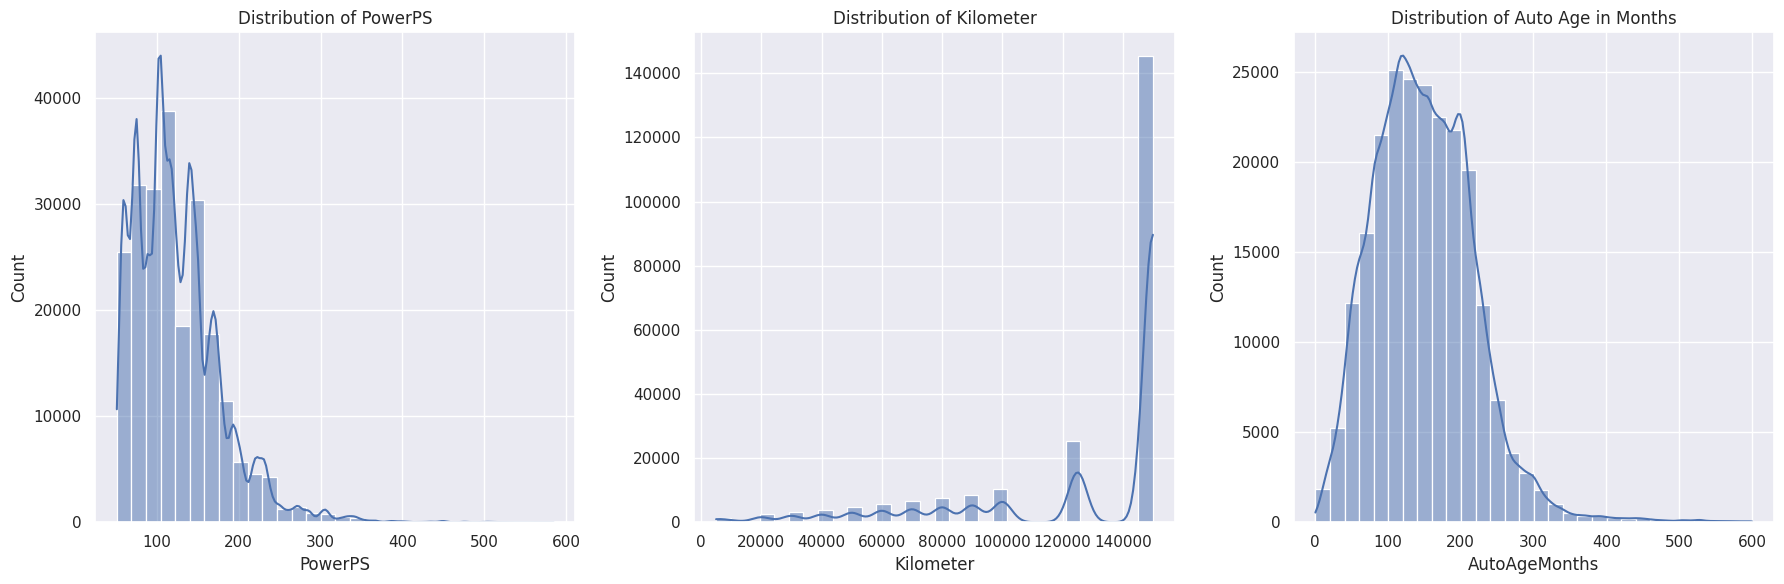

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(filtered_data['powerPS'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of PowerPS')
axes[0].set_xlabel('PowerPS')

sns.histplot(filtered_data['kilometer'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Kilometer')
axes[1].set_xlabel('Kilometer')

sns.histplot(filtered_data['autoAgeMonths'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Auto Age in Months')
axes[2].set_xlabel('AutoAgeMonths')

plt.tight_layout()
plt.show()

In [8]:
Q1 = filtered_data['powerPS'].quantile(0.25)
Q3 = filtered_data['powerPS'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = filtered_data[(filtered_data['powerPS'] >= lower_bound) & (filtered_data['powerPS'] <= upper_bound)]

filtered_data['log_powerPS'] = np.log(filtered_data['powerPS'])

correlation_powerPS = filtered_data['log_price'].corr(filtered_data['powerPS'])
correlation_log_powerPS = filtered_data['log_price'].corr(filtered_data['log_powerPS'])

correlation_powerPS, correlation_log_powerPS

<ipython-input-8-a676087c26ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['log_powerPS'] = np.log(filtered_data['powerPS'])


(0.45544178790671963, 0.46458889473283016)

In [9]:
Q1 = filtered_data['autoAgeMonths'].quantile(0.25)
Q3 = filtered_data['autoAgeMonths'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = filtered_data[(filtered_data['autoAgeMonths'] >= lower_bound) & (filtered_data['autoAgeMonths'] <= upper_bound)]

correlation_autoAgeMonths = filtered_data['log_price'].corr(filtered_data['autoAgeMonths'])

correlation_autoAgeMonths

-0.708092462005879

#### Обработка данных

In [ ]:
print(filtered_data['gearbox'].unique())
print(filtered_data['notRepairedDamage'].unique())

['manuell' 'automatik']
['nein' 'ja']


In [10]:
filtered_data['gearbox_binary'] = filtered_data['gearbox'].apply(lambda x: 0 if x == 'manuell' else 1)
filtered_data['notRepairedDamage_binary'] = filtered_data['notRepairedDamage'].apply(lambda x: 0 if x == 'nein' else 1)

In [11]:
categorical = ['brand', 'vehicleType', 'fuelType']
numeric = ['log_powerPS', 'kilometer', 'autoAgeMonths']
binary = ['gearbox_binary', 'notRepairedDamage_binary']

In [12]:
filtered_data = filtered_data.drop(columns=['gearbox', 'notRepairedDamage'])

In [13]:
#filtered_data['bias'] = 1
#other += ['bias']

x = filtered_data[categorical + numeric + binary]
y = filtered_data['log_price']

Для кодирования оставшихся категориальных переменных будет использоваться Target Encoding с добавлением сглаживания для кодирования категориальных переменных, поскольку это позволяет учитывать среднее значение целевой переменной для каждой категории, не создавая значительных рисков переобучения. Сглаживание снижает влияние редких категорий и улучшает стабильность модели, комбинируя среднее значение категории с общим средним значением по всему набору данных.

Сглаживание особенно полезно для редких и отсутствующих категорий, так как оно уменьшает вес редких значений, минимизируя риск того, что модель будет слишком сильно учитывать уникальные значения, которые могут не появляться в будущем

Ресурсы:
https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem04-features.pdf

https://www.kaggle.com/code/ryanholbrook/target-encoding

https://habr.com/ru/articles/544666/

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import TargetEncoder
from sklearn.impute import SimpleImputer

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler(with_mean=False))
])



binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric),
        ('cat', categorical_transformer, categorical),
        ('binary', binary_transformer, binary)
    ]
)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

y_train = np.array(y_train).astype(float)
y_val = np.array(y_val).astype(float)
y_test = np.array(y_test).astype(float)

In [17]:
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

In [18]:
X_train.shape[1]

58

## Задание 5. Сравнение методов градиентного спуска (2 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

### Задание 5.1. Подбор оптимальной длины шага (1 балл)

Подберите по валидационной выборке наилучшую длину шага $\lambda$ для каждого метода с точки зрения ошибки. Для этого сделайте перебор по логарифмической сетке. Для каждого метода посчитайте ошибку на обучающей и тестовой выборках, посчитайте качество по метрике $R^2$, сохраните количество итераций до сходимости.

Все параметры кроме `lambda_` стоит выставить равным значениям по умолчанию.

In [21]:
from sklearn.metrics import r2_score
def calc_methods_lr(X_train, y_train, X_val, y_val, X_test, y_test, methods_list, lr_list):
    np.random.seed(42)

    results = []

    for method in methods_list:
        best_val_r2 = -np.inf
        best_lambda = None
        best_iterations = None
        for lr in lr_list:
            descent_config = {
                'descent_name': method,
                'kwargs': {
                    'dimension': X_train.shape[1],
                    'lambda_': lr
                }
            }


            model = LinearRegression(descent_config=descent_config)

            model.fit(X_train, y_train)

            iterations = len(model.loss_history)

            loss_train = model.calc_loss(X_train, y_train)
            loss_val = model.calc_loss(X_val, y_val)
            loss_test = model.calc_loss(X_test, y_test)

            y_pred_val = model.predict(X_val)
            r2_val = r2_score(y_val, y_pred_val)


            if r2_val > best_val_r2:
                best_val_r2 = r2_val
                best_lambda = lr
                best_iterations = iterations
                best_model = model
                best_loss_train = loss_train
                best_loss_val = loss_val
                best_loss_test = loss_test
                y_pred_train_best = model.predict(X_train)
                y_pred_test_best = model.predict(X_test)


        r2_train = r2_score(y_train, y_pred_train_best)
        r2_test = r2_score(y_test, y_pred_test_best)

        results.append({
            'method': method,
            'best_lambda': best_lambda,
            'iterations': best_iterations,
            'loss_train': best_loss_train,
            'loss_val': best_loss_val,
            'loss_test': best_loss_test,
            'r2_train': r2_train,
            'r2_val': best_val_r2,
            'r2_test': r2_test
        })

    return results

methods_list = ['full', 'stochastic', 'momentum', 'adam']
lr_list = np.arange(0.025, 0.035, 0.001)

results = calc_methods_lr(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    methods_list,
    lr_list
)


for res in results:
    print(f"Метод: {res['method']}")
    print(f"  Наилучшая длина шага: {res['best_lambda']}")
    print(f"  Итерации: {res['iterations']}")
    print(f"  Loss на обучении: {res['loss_train']}")
    print(f"  Loss на валидации: {res['loss_val']}")
    print(f"  Loss на тесте: {res['loss_test']}")
    print(f"  R^2 на обучении: {res['r2_train']}")
    print(f"  R^2 на валидации: {res['r2_val']}")
    print(f"  R^2 на тесте: {res['r2_test']}")
    print()

Метод: full
  Наилучшая длина шага: 0.03300000000000001
  Итерации: 23
  Loss на обучении: 0.5488200685789644
  Loss на валидации: 0.5339938870681741
  Loss на тесте: 0.5422562635165009
  R^2 на обучении: 0.017930646265435723
  R^2 на валидации: 0.028083157516841428
  R^2 на тесте: 0.008660228897984346

Метод: stochastic
  Наилучшая длина шага: 0.025
  Итерации: 301
  Loss на обучении: 171278.3550986423
  Loss на валидации: 171559.82856492474
  Loss на тесте: 172056.09028041788
  R^2 на обучении: -306487.8351039611
  R^2 на валидации: -312253.29899815685
  R^2 на тесте: -314547.7781905665

Метод: momentum
  Наилучшая длина шага: 0.03200000000000001
  Итерации: 60
  Loss на обучении: 0.27241992725307884
  Loss на валидации: 0.26564270243049437
  Loss на тесте: 0.2613944149946843
  R^2 на обучении: 0.512526459546996
  R^2 на валидации: 0.5165064192167848
  R^2 на тесте: 0.5221250597499272

Метод: adam
  Наилучшая длина шага: 0.03500000000000001
  Итерации: 100
  Loss на обучении: 0.22537

### Задание 5.2. Сравнение методов (1 балла)

Постройте график зависимости ошибки на обучающей выборке от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты (таблички с метриками и график). Сравните методы между собой.

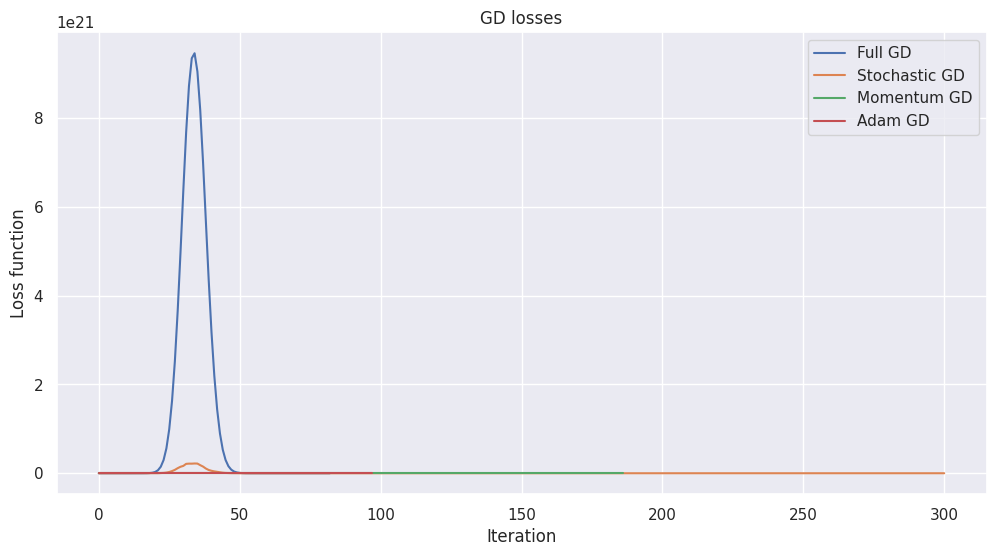

In [ ]:
def calc_losses(X_train, y_train):

  losses_all = {}


  for gd in ['full', 'stochastic', 'momentum', 'adam']:
    np.random.seed(42)

    descent_config = {
    'descent_name': gd,
    'kwargs': {
        'dimension': 58,
        'lambda_': best_lambda}
    }

    model = LinearRegression(descent_config=descent_config)
    model.fit(X_train, y_train)
    losses_all[gd] = model.loss_history

  plt.figure(figsize=(12, 6))
  for gd_name in ['full', 'stochastic', 'momentum', 'adam']:
    losses = losses_all[gd_name]
    plt.plot(range(len(losses)), losses, label=f'{gd_name.capitalize()} GD')

  plt.title('GD losses')
  plt.xlabel('Iteration')
  plt.ylabel('Loss function')
  plt.legend()
  plt.grid(True)
  plt.show()

calc_losses(X_train, y_train)

###**Выводы**

Полный градиентный спуск (Full GD) демонстрирует резкий пик функции потерь на начальных итерациях, что указывает на его чувствительность к выбору шага обучения. Этот метод, в отличие от остальных, менее устойчив при завышенном learning rate, что приводит к нестабильной динамике и резким скачкам ошибки. Такая особенность делает его менее предпочтительным при использовании высоких значений шага обучения и может вызывать трудности с сходимостью.

Stochastic GD, Momentum GD и Adam показывают более плавное и предсказуемое снижение функции потерь. Stochastic GD проявляет небольшие колебания, характерные для этого метода, но не демонстрирует резких выбросов, как Full GD. Momentum GD сглаживает колебания за счет использования накопленного градиента, что ускоряет сходимость и повышает устойчивость. Adam адаптирует шаг обучения для каждой переменной, что позволяет ему достигать быстрой и стабильной сходимости с минимальными колебаниями, делая его наиболее устойчивым из представленных методов.

## Задание 6. Стохастический градиентный спуск и размер батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска.

* Сделайте по несколько запусков (например, k = 10) стохастического градиентного спуска на обучающей выборке для каждого размера батча из перебираемого списка. Замерьте время в секундах и количество итераций до сходимости. Посчитайте среднее этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча. _(под сходимостью понимается достижение критерия останова)_
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

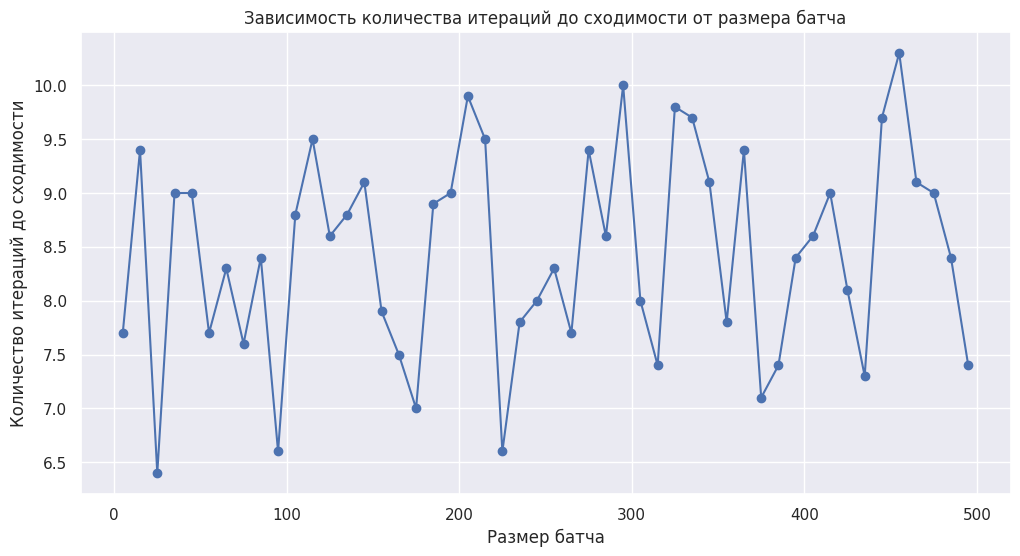

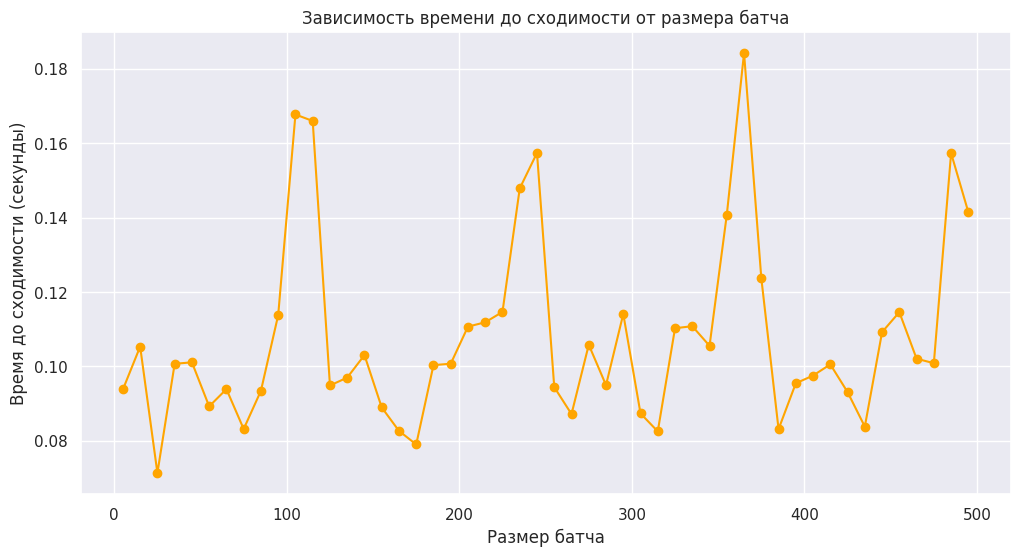

In [ ]:
batch_sizes = np.arange(5, 500, 10)
import time

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': X_train.shape[1]
    }
}

def calc_batches(batch_sizes, x_train, y_train, k=10):

    avg_times = []
    avg_iterations = []

    for batch_size in batch_sizes:
        total_time = 0
        total_iterations = 0

        for i in range(k):

            current_descent_config = descent_config.copy()
            current_descent_config['kwargs'] = descent_config['kwargs'].copy()
            current_descent_config['kwargs']['batch_size'] = batch_size

            model = LinearRegression(descent_config=descent_config)

            start_time = time.time()
            model.fit(x_train, y_train)
            end_time = time.time()

            total_time += (end_time - start_time)
            total_iterations += len(model.loss_history)

        avg_time = total_time / k
        avg_iteration = total_iterations / k

        avg_times.append(avg_time)
        avg_iterations.append(avg_iteration)

    return avg_times, avg_iterations


avg_times, avg_iterations = calc_batches(batch_sizes, X_train, y_train, k=10)


plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, avg_iterations, marker='o')
plt.title('Зависимость количества итераций до сходимости от размера батча')
plt.xlabel('Размер батча')
plt.ylabel('Количество итераций до сходимости')
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, avg_times, marker='o', color='orange')
plt.title('Зависимость времени до сходимости от размера батча')
plt.xlabel('Размер батча')
plt.ylabel('Время до сходимости (секунды)')
plt.grid(True)
plt.show()

1. **Зависимость количества итераций до сходимости от размера батча**: Количество итераций, необходимых для достижения сходимости, изменяется непредсказуемо при разных размерах батча. Это указывает на то, что размер батча не оказывает линейного влияния на количество итераций до сходимости. В некоторых случаях, увеличение размера батча приводит к снижению количества итераций, но в других случаях, напротив, вызывает рост.
2. **Зависимость времени до сходимости от размера батча**: Время до сходимости также варьируется в зависимости от размера батча, показывая пики при определенных значениях (например, около 100 и 400). Это говорит о том, что для некоторых размеров батча процесс обучения занимает больше времени, что может быть связано с увеличением вычислительных затрат на обработку большего количества данных в каждом батче.

Можно прийти к выводу, что подбор оптимального размера батча для стохастического градиентного спуска требует экспериментального подхода, так как не существует универсального размера, обеспечивающего наилучшее время сходимости при минимальном количестве итераций.

## Задание 7. Регуляризация (1 балл)

В этом задании вам предстоит исследовать влияние регуляризации на работу различных методов градиентного спуска. Напомним, регуляризация - это добавка к функции потерь, которая штрафует за норму весов. Мы будем использовать l2 регуляризацию, таким образом функция потерь приобретает следующий вид:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2 + \dfrac{\mu}{2} \| w \|^2
$$

In [ ]:
from descents import get_descent

Допишите класс **BaseDescentReg** в файле `descents.py`.

Протестируйте ваше решение в контесте.

Вставьте ссылку на успешную посылку:

* **BaseDescentReg**: https://contest.yandex.ru/contest/70588/run-report/124805089/

Найдите лучшие параметры обучения с регуляризацией аналогично 5 заданию. Будем подбирать длину шага $\lambda$ (`lambda_`) и коэффициент регуляризации $\mu$ (`mu`).

Сравните для каждого метода результаты с регуляризацией и без регуляризации (нужно опять сохранить ошибку и качество по метрике $R^2$ на обучающей и тестовой выборках и количество итераций до сходимости).

Постройте для каждого метода график со значениями функции потерь MSE с регуляризацией и без регуляризации (всего должно получиться 4 графика).

Посмотрите на получившиеся результаты. Какие можно сделать выводы, как регуляризация влияет на сходимость? Как изменилось качество на обучающей выборке? На тестовой? Чем вы можете объяснить это?

In [28]:
def tune_hyperparameters(X_train, y_train, X_val, y_val, X_test, y_test, methods_list, lambda_list, mu_list):
    np.random.seed(42)

    results = []

    for method in methods_list:

        best_val_r2_no_reg = -np.inf
        best_lambda_no_reg = None
        best_iterations_no_reg = None

        for lambda_ in lambda_list:
            descent_config = {
                'descent_name': method,
                'kwargs': {
                    'dimension': X_train.shape[1],
                    'lambda_': lambda_
                }
            }

            model_no_reg = LinearRegression(descent_config=descent_config)
            model_no_reg.fit(X_train, y_train)

            y_pred_val = model_no_reg.predict(X_val)
            r2_val = r2_score(y_val, y_pred_val)

            if r2_val > best_val_r2_no_reg:
                best_val_r2_no_reg = r2_val
                best_lambda_no_reg = lambda_
                best_iterations_no_reg = len(model_no_reg.loss_history)
                best_model_no_reg = model_no_reg

        best_val_r2_reg = -np.inf
        best_lambda_reg = None
        best_mu_reg = None
        best_iterations_reg = None

        for lambda_ in lambda_list:
            for mu in mu_list:
                descent_config = {
                    'descent_name': method,
                    'regularized': True,
                    'kwargs': {
                        'dimension': X_train.shape[1],
                        'lambda_': lambda_,
                        'mu': mu
                    }
                }




                model_reg = LinearRegression(descent_config=descent_config)
                model_reg.fit(X_train, y_train)

                y_pred_val = model_reg.predict(X_val)
                r2_val = r2_score(y_val, y_pred_val)

                if r2_val > best_val_r2_reg:
                    best_val_r2_reg = r2_val
                    best_lambda_reg = lambda_
                    best_mu_reg = mu
                    best_iterations_reg = len(model_reg.loss_history)
                    best_model_reg = model_reg

        results.append({
            'method': method,
            'no_reg': {
                'model': best_model_no_reg,
                'lambda_': best_lambda_no_reg,
                'iterations': best_iterations_no_reg,
                'r2_train': r2_score(y_train, best_model_no_reg.predict(X_train)),
                'r2_test': r2_score(y_test, best_model_no_reg.predict(X_test)),
                'loss_history': best_model_no_reg.loss_history
            },
            'reg': {
                'model': best_model_reg,
                'lambda_': best_lambda_reg,
                'mu': best_mu_reg,
                'iterations': best_iterations_reg,
                'r2_train': r2_score(y_train, best_model_reg.predict(X_train)),
                'r2_test': r2_score(y_test, best_model_reg.predict(X_test)),
                'loss_history': best_model_reg.loss_history
            }
        })

    return results

In [30]:
methods_list = ['full', 'stochastic', 'momentum', 'adam']
lambda_list = np.linspace(0.001, 0.1, 8)
mu_list = np.linspace(0.001, 0.1, 8)


results = tune_hyperparameters(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    methods_list,
    lambda_list,
    mu_list
)
for res in results:
    method = res['method']
    print(f"Метод: {method}")

    print("  Без регуляризации:")
    print(f"    Наилучшая длина шага (lambda_): {res['no_reg']['lambda_']}")
    print(f"    Итерации: {res['no_reg']['iterations']}")
    print(f"    R^2 на обучении: {res['no_reg']['r2_train']}")
    print(f"    R^2 на тесте: {res['no_reg']['r2_test']}")

    print("  С регуляризацией:")
    print(f"    Наилучшая длина шага (lambda_): {res['reg']['lambda_']}")
    print(f"    Коэффициент регуляризации (mu): {res['reg']['mu']}")
    print(f"    Итерации: {res['reg']['iterations']}")
    print(f"    R^2 на обучении: {res['reg']['r2_train']}")
    print(f"    R^2 на тесте: {res['reg']['r2_test']}")
    print()

Метод: full
  Без регуляризации:
    Наилучшая длина шага (lambda_): 0.05757142857142857
    Итерации: 63
    R^2 на обучении: 0.3305146435475137
    R^2 на тесте: 0.338782313177593
  С регуляризацией:
    Наилучшая длина шага (lambda_): 0.07171428571428572
    Коэффициент регуляризации (mu): 0.05757142857142857
    Итерации: 97
    R^2 на обучении: 0.4671039267789746
    R^2 на тесте: 0.4801954978228741

Метод: stochastic
  Без регуляризации:
    Наилучшая длина шага (lambda_): 0.015142857142857142
    Итерации: 23
    R^2 на обучении: -0.5691608993537383
    R^2 на тесте: -0.5903580608735719
  С регуляризацией:
    Наилучшая длина шага (lambda_): 0.015142857142857142
    Коэффициент регуляризации (mu): 0.015142857142857142
    Итерации: 18
    R^2 на обучении: 0.4387253790886799
    R^2 на тесте: 0.4453315297565794

Метод: momentum
  Без регуляризации:
    Наилучшая длина шага (lambda_): 0.04342857142857143
    Итерации: 112
    R^2 на обучении: 0.38721181122323056
    R^2 на тесте: 

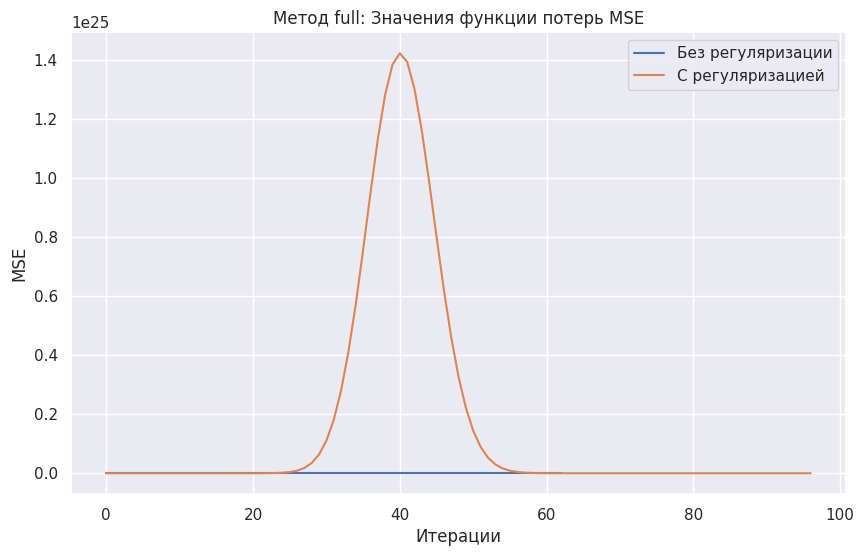

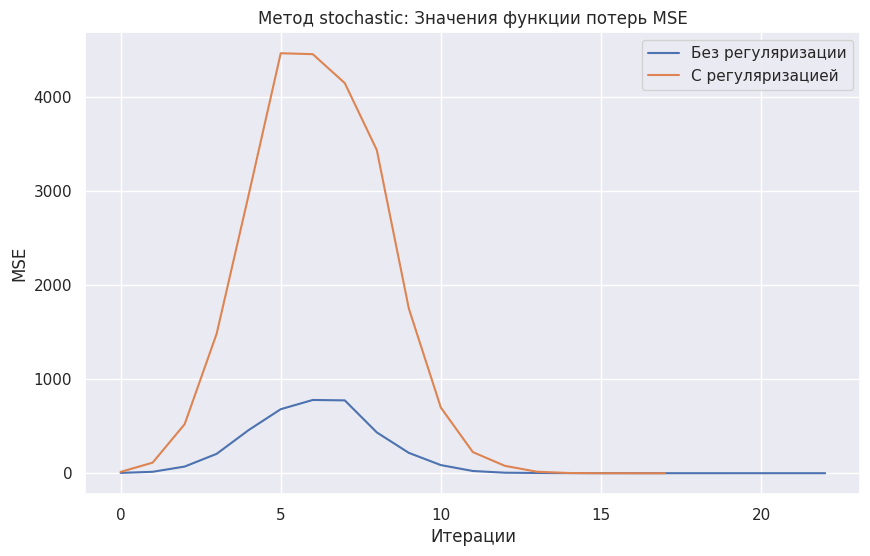

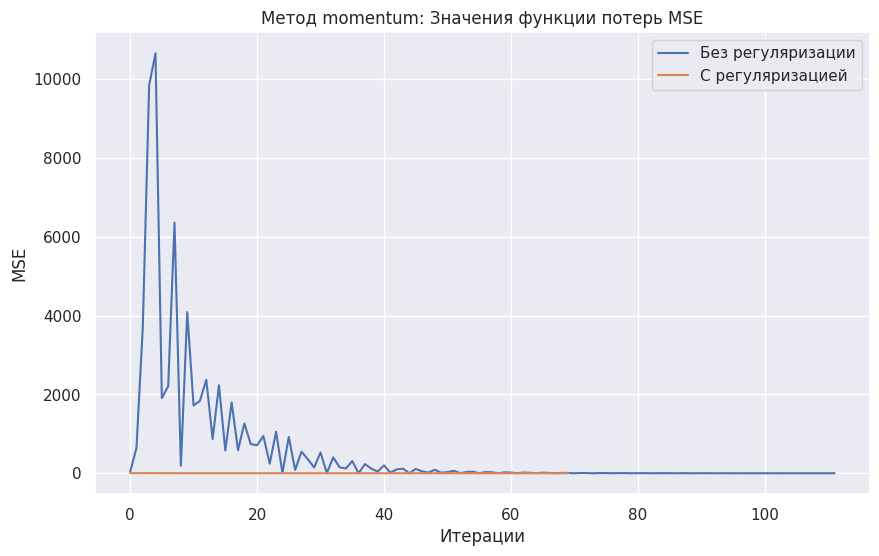

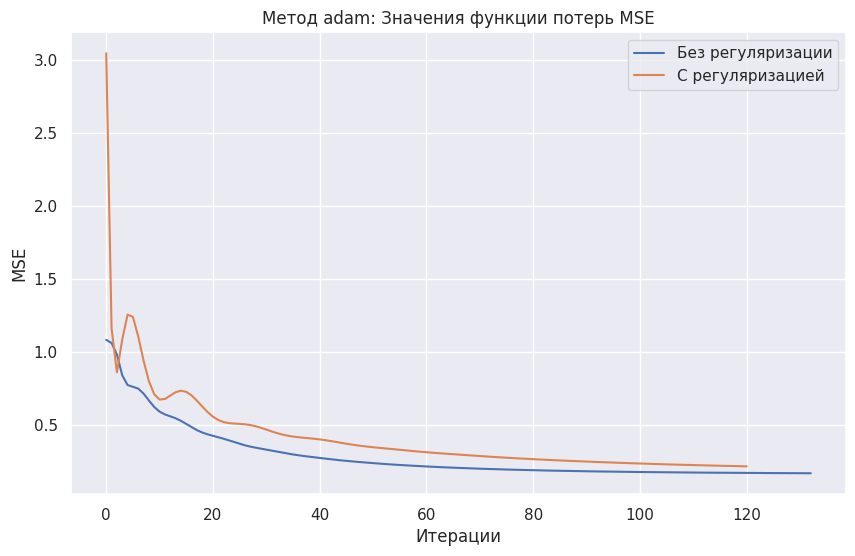

In [35]:
for res in results:
    method = res['method']
    loss_history_no_reg = res['no_reg']['loss_history']
    loss_history_reg = res['reg']['loss_history']

    plt.figure(figsize=(10, 6))
    plt.plot(loss_history_no_reg, label='Без регуляризации')
    plt.plot(loss_history_reg, label='С регуляризацией')
    plt.title(f'Метод {method}: Значения функции потерь MSE')
    plt.xlabel('Итерации')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

Регуляризация влияет на сходимость, меняя скорость оптимизации и качество модели. В методе Full регуляризация увеличила количество итераций, так как штраф на сложность модели потребовал больше времени на поиск оптимальных параметров. В стохастическом и методе Momentum, напротив, регуляризация уменьшила число итераций, вероятно, стабилизировав и направив градиенты, что ускорило процесс. В Adam количество итераций также снизилось, поскольку регуляризация помогает избежать переобучения и, соответственно, ускоряет достижение сходимости.

Качество модели улучшилось на тестовой выборке во всех методах благодаря регуляризации, что указывает на её роль в предотвращении переобучения и повышении обобщающей способности. На обучающей выборке показатели R² также улучшились, за исключением Adam, где регуляризация привела к небольшому снижению R² на обучении и на тесте.

## Задание 8. Альтернативная функция потерь (1 балл)
В этом задании вам предстоит использовать другую функцию потерь для нашей задачи регрессии. В качестве функции потерь мы выбрали **Log-Cosh**:

$$
L(y, a) = \log\left(\cosh(a - y)\right).
$$

Самостоятельно продифференцируйте данную функцию потерь чтобы найти её градиент _(требуется показать не только результат, но и промежуточные вычисления)_:

$$
L(y, a) = \log\left(\cosh(a - y)\right)
$$
$$
\frac{d}{da} \log\left(\cosh(a - y)\right)
$$
$$
\frac{d}{da} \log\left(\cosh(a - y)\right) = \frac{1}{\cosh(a - y)} \cdot \frac{d}{da} \cosh(a - y)
$$
$$
\frac{d}{da} \cosh(a - y) = \sinh(a - y)
$$
$$
\frac{d}{da} \log\left(\cosh(a - y)\right) = \frac{\sinh(a - y)}{\cosh(a - y)}
$$
$$
\frac{d}{da} L(y, a) = \tanh(a - y)
$$
$$
\nabla_a L(y, a) = \tanh(a - y)
$$


Программно реализуйте градиентный спуск с данной функцией потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Пример того, как можно запрограммировать использование нескольких функций потерь внутри одного класса градиентного спуска:


```python
from enum import auto
from enum import Enum

import numpy as np

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

...
class BaseDescent:
    def __init__(self, loss_function: LossFunction = LossFunction.MSE):
        self.loss_function: LossFunction = loss_function

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            return ...
        elif self.loss_function is LossFunction.LogCosh:
            return ...
...

```

In [31]:
def calc_methods_lr(X_train, y_train, X_val, y_val, X_test, y_test, methods_list, lr_list, loss_function):
    np.random.seed(42)

    results = []

    for method in methods_list:
        best_val_r2 = -np.inf
        best_lambda = None
        best_iterations = None
        for lr in lr_list:
            descent_config = {
                'descent_name': method,
                'kwargs': {
                    'dimension': X_train.shape[1],
                    'lambda_': lr,
                    'loss_function': loss_function
                }
            }

            model = LinearRegression(descent_config=descent_config)

            model.fit(X_train, y_train)

            iterations = len(model.loss_history)

            loss_train = model.calc_loss(X_train, y_train)
            loss_val = model.calc_loss(X_val, y_val)
            loss_test = model.calc_loss(X_test, y_test)

            y_pred_val = model.predict(X_val)
            r2_val = r2_score(y_val, y_pred_val)

            if r2_val > best_val_r2:
                best_val_r2 = r2_val
                best_lambda = lr
                best_iterations = iterations
                best_model = model
                best_loss_train = loss_train
                best_loss_val = loss_val
                best_loss_test = loss_test
                y_pred_train_best = model.predict(X_train)
                y_pred_test_best = model.predict(X_test)

        r2_train = r2_score(y_train, y_pred_train_best)
        r2_test = r2_score(y_test, y_pred_test_best)

        results.append({
            'method': method,
            'best_lambda': best_lambda,
            'iterations': best_iterations,
            'loss_train': best_loss_train,
            'loss_val': best_loss_val,
            'loss_test': best_loss_test,
            'r2_train': r2_train,
            'r2_val': best_val_r2,
            'r2_test': r2_test
        })

    return results

In [33]:
methods_list = ['full', 'stochastic', 'momentum', 'adam']
lr_list = np.arange(0.025, 0.035, 0.001)




results_logcosh = calc_methods_lr(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    methods_list,
    lr_list,
    loss_function=LossFunction.LogCosh
)


In [34]:
for res in results_logcosh:
    print(f"Метод: {res['method']}")
    print(f"  Наилучшая длина шага: {res['best_lambda']}")
    print(f"  Итерации: {res['iterations']}")
    print(f"  Loss на обучении: {res['loss_train']}")
    print(f"  Loss на валидации: {res['loss_val']}")
    print(f"  Loss на тесте: {res['loss_test']}")
    print(f"  R^2 на обучении: {res['r2_train']}")
    print(f"  R^2 на валидации: {res['r2_val']}")
    print(f"  R^2 на тесте: {res['r2_test']}")
    print()

Метод: full
  Наилучшая длина шага: 0.03300000000000001
  Итерации: 23
  Loss на обучении: 0.5488200685789644
  Loss на валидации: 0.5339938870681741
  Loss на тесте: 0.5422562635165009
  R^2 на обучении: 0.017930646265435723
  R^2 на валидации: 0.028083157516841428
  R^2 на тесте: 0.008660228897984346

Метод: stochastic
  Наилучшая длина шага: 0.025
  Итерации: 301
  Loss на обучении: 171278.3550986423
  Loss на валидации: 171559.82856492474
  Loss на тесте: 172056.09028041788
  R^2 на обучении: -306487.8351039611
  R^2 на валидации: -312253.29899815685
  R^2 на тесте: -314547.7781905665

Метод: momentum
  Наилучшая длина шага: 0.03200000000000001
  Итерации: 60
  Loss на обучении: 0.27241992725307884
  Loss на валидации: 0.26564270243049437
  Loss на тесте: 0.2613944149946843
  R^2 на обучении: 0.512526459546996
  R^2 на валидации: 0.5165064192167848
  R^2 на тесте: 0.5221250597499272

Метод: adam
  Наилучшая длина шага: 0.03500000000000001
  Итерации: 100
  Loss на обучении: 0.22537

Метод MSE демонстрирует более высокую Loss для Stochastic, который указывает на значительные ошибки предсказаний, и его R² отрицательно на всех выборках, что указывает на неудачную сходимость. Наилучший результат при MSE достигается методом Adam, где минимальная Loss на тесте сопровождается наибольшим значением R², что говорит о хорошей способности Adam объяснять вариации данных при минимальных ошибках.

При использовании log-cosh значения Loss остаются теми же, что и для MSE, но можно заметить более устойчивую динамику R² по методам. Log-cosh также демонстрирует лучшее качество на тестовой выборке для методов Momentum и Adam, где R² выше, что говорит о повышенной способности к точным предсказаниям и хорошей обобщающей способности модели. Таким образом, log-cosh подтверждает, что Adam и Momentum подходят лучше для этой задачи, а Stochastic демонстрирует плохую сходимость при обеих метриках.

### Кулинарно-социализационный бонус. (0.5 балла).

Как мы знаем, осень прекрасная пора, время пробовать новое и делиться теплом с друзьями и близкими. Выберите рецепт, который соответствует вашему настроению, приготовьте выбранное блюдо и угостите хотя бы одного человека им. Кратко опишите ваши впечатления, прикрепите рецепт и фотографии блюда и довольного гостя.

Я выбрала приготовить булочки с творогом — наше семейное блюдо. Давно не виделась с мамой, поэтому решила сделать что-то привычное из детства. В процессе отвлеклась от математических курсов и работы, получилось полезно провести время и в итоге порадовать маму.

Рецепт: https://www.povarenok.ru/recipes/show/111421/

Ссылка на фото: https://drive.google.com/drive/folders/1SfduasQiQrmr7JXM7xf9rVmw8kow3Vta?usp=sharing


### Бонус 1. Другие методы градиентного спуска (1 балл).

По желанию выберите метод градиентного спуска из следующего списка и самостоятельно реализуйте его в файле `descents.py`. Обучите линейную регрессию с помощью этого метода, сравните с методами из основной части домашнего задания.

`AdaMax` (вариация Adam основанная на $l_{\infty}$), `Nadam` (вариация Adam совмещенная с методом импульса Нестерова), `AMSGrad` (ещё одна вариация Adam).

In [ ]:
# YOUR CODE:

### Бонус 2. Другие функции потерь (1 балл).

Аналогично 8 заданию реализуйте две функции потерь - **MAE** и **Huber**.

Самостоятельно продифференцируйте данные функции потерь, чтобы найти их градиенты _(требуется показать не только результат, но и промежуточные вычисления)_:

`### ваше решение тут ###`

Программно реализуйте градиентный спуск с данными функциями потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Сравните между собой *для каждого метода отдельно* качество для разных функций потерь. Какая оказалась лучше? Как вы думаете почему?

In [ ]:
# YOUR CODE: